# **Speed Limit Recognition**
Thomas,Kyle,Makaila,Payne,Jay

## Mount Drive

In [ ]:
import os
from google.colab import drive
drive.mount("/content/drive")

dir = '/content/drive/MyDrive/4152 5152 Group Work/'

Mounted at /content/drive


In [ ]:
cd '$dir'

/content/drive/.shortcut-targets-by-id/1tKax_EoJ0f7h5nV1cHLcD78taQJYqZ_4/4152 5152 Group Work


## Import packages

In [ ]:
import cv2, uuid, random
import numpy as np
import tensorflow as tf
from google.colab.patches import cv2_imshow
from utils import Preprocess

%pylab inline

# Ensure tensorflow version is correct
print("\nTensorflow loaded. Version " + str(tf.__version__) + "\n")

Populating the interactive namespace from numpy and matplotlib

Tensorflow loaded. Version 2.8.0



/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Preprocess Data

In [ ]:
print(f"\nLoading dataset. Please wait...")

# Load raw dataset
dataset = Preprocess.loadDataset(image_dims=[64,64])

# Removed extra data folders
del dataset['all']
del dataset['classed']
del dataset['60']
del dataset["speed limit signs"]
del dataset['extra']

# Print number of samples for each speed limit
for key in sorted(dataset):
  print(f"Samples for {key}mph: {len(dataset[key])}")


# Split data into training, validation, and testing sets
def split_dataset(dataset, train_pct, test_pct, valid_pct):
  train_data = {}
  test_data = {}
  valid_data = {}

  # Loop through keys (speed limits) in dataset
  for i,key in enumerate(dataset):
    # Compute number of samples for each set
    n_train_samples = int(len(dataset[key])*train_pct)
    n_test_samples = int(len(dataset[key])*test_pct)
    n_valid_samples = int(len(dataset[key])*valid_pct)

    # Populate datasets
    train_data[key] = dataset[key][:n_train_samples]
    test_data[key] = dataset[key][n_train_samples+1:n_train_samples+1+n_test_samples]
    valid_data[key] = dataset[key][n_train_samples+n_test_samples+2:]


  # I'm sure there's a better way to do this but it works
  _train = []
  _test = []
  _valid = []

  # Reformat data into a single array
  for key in train_data:
    for sample in train_data[key]:
      _train.append(sample)
    for sample in test_data[key]:
      _test.append(sample)
    for sample in valid_data[key]:
      _valid.append(sample)


  return _train, _test, _valid


# Split dataset
train_pct = 0.7
test_pct = 0.1
valid_pct = 0.2
train_data, test_data, valid_data = split_dataset(dataset, train_pct, test_pct, valid_pct)

print(f"\nTrain split: {train_pct*100.0}%\tTest split: {test_pct*100.0}%\tValidation split: {valid_pct*100.0}%\n")


Loading dataset. Please wait...
Samples for 25mph: 587
Samples for 30mph: 157
Samples for 35mph: 141
Samples for 40mph: 87
Samples for 45mph: 77
Samples for 50mph: 48

Train split: 70.0%	Test split: 10.0%	Validation split: 20.0%




Training samples: 763	Validation samples: 216	Test samples: 106


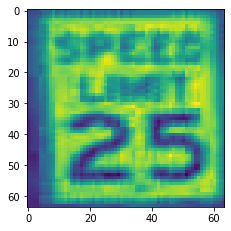

In [ ]:
# Pick a random sample from the dataset
def random_sample(data):
  return random.choice(data)["image"]

r_sample = random_sample(valid_data)
fig = figure(0, (16, 8))
fig.add_subplot(2,3,1)
imshow(r_sample)

## Create, Train, & Save Model

### Resources
- Tensorflow Adamax optimizer: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adamax
- Adam: A Method for Stochastic Optimization: http://arxiv.org/abs/1412.6980
- Pooling Methods in Deep Neural Networks: https://arxiv.org/ftp/arxiv/papers/2009/2009.07485.pdf

In [ ]:
# Model class
class SpeedLimitCNN:

  # Initialize model
  def __init__(self, train_data, test_data, valid_data):
    # Inputs and labels
    self.train_inputs = [sample["image"] for sample in train_data]
    self.train_labels = [int(sample["label"]) for sample in train_data]
    self.test_inputs = [sample["image"] for sample in test_data]
    self.test_labels = [int(sample["label"]) for sample in test_data]
    self.valid_inputs = [sample["image"] for sample in valid_data]
    self.valid_labels = [int(sample["label"]) for sample in valid_data]
    self.model_dir = dir + 'models/'

    print(f"Model dir: {self.model_dir}")

    self.image_dims = np.array(train_data[0]['image']).shape

    labels = np.unique(self.train_labels)

    """
    One hot encode labels.

    [1,0,0,0,0,0] = 25mph
    [0,1,0,0,0,0] = 30mph
    [0,0,1,0,0,0] = 35mph
    [0,0,0,1,0,0] = 40mph
    [0,0,0,0,1,0] = 45mph
    [0,0,0,0,0,1] = 50mph
    """
    _train_labels = []
    for j in range(len(self.train_labels)):
      for i, label in enumerate(labels):
        if self.train_labels[j] == label:
          one_hot = np.zeros(len(labels), dtype=int)
          one_hot[i] = 1
          _train_labels.append(one_hot)
    self.train_labels = _train_labels

    _test_labels = []
    for j in range(len(self.test_labels)):
      for i, label in enumerate(labels):
        if self.test_labels[j] == label:
          one_hot = np.zeros(len(labels), dtype=int)
          one_hot[i] = 1
          _test_labels.append(one_hot)
    self.test_labels = _test_labels

    _valid_labels = []
    for j in range(len(self.valid_labels)):
      for i, label in enumerate(labels):
        if self.valid_labels[j] == label:
          one_hot = np.zeros(len(labels), dtype=int)
          one_hot[i] = 1
          _valid_labels.append(one_hot)
    self.valid_labels = _valid_labels

    # Hyperparameters
    self.epochs = 500                       #   Number of training epochs
    self.batch_size = 10                    #   Number of samples to train per epoch
    self.n_hidden = 4096                    #   Number of nodes in the first hidden layer
    self.n_outputs = 6                      #   6 outputs, 1 for each speed limit
    self.hidden_activation = 'relu'         #   Activation function for hidden layers
    self.output_activation = 'softmax'      #   Output activation (softmax because we want a multi-class probability distribution as our output)
    self.learning_rate = 0.000105           #   Learning rate for training the model
    self.m1_decay = 0.99                    #   First moments decay (specifically for Adam and Adamax optimizers)
    self.m2_decay = 0.999                   #   Second moments decay (also specifically for Adam/Adamax optimizers)
    self.stabilizer = 1e-07                 #   Numerical constant for avoiding 0s and stabilizing parameter updates
    self.n_filters = 32                     #   Number of convolutional filters to apply/train
    self.filter_shape = [3,3]               #   Shape of kernel for conv. filter
    self.max_pool_shape = [4,4]             #   Shape of matrix for applying max pooling 
    self.avg_pool_shape = [3,3]             #   Shape of matrix for applying average pooling

    # Configure training algorithim (optimizer)
    self.optimizer = tf.keras.optimizers.Adam(
                                                self.learning_rate,
                                                self.m1_decay,
                                                self.m2_decay,
                                                self.stabilizer
                                                )
    
    """
      Set loss function. 
      
      Catergorical Cross-Entropy was chosen because it provides a relative ratio of 
      misclassified labels in a multi-class classification task. Basically, it's
      a metric that represents how many samples of each class are labelled correctly/incorrectly
      relative to the entire training set. 

      Each class can be thought of as a 'category'
    """
    self.loss_func = tf.keras.losses.CategoricalCrossentropy()


    # Model
    self.model = tf.keras.models.Sequential([
        # Apply first set of convolutional filters to the inputs
        tf.keras.layers.Conv2D(self.n_filters,self.filter_shape,activation=self.hidden_activation,input_shape=(self.image_dims[0],self.image_dims[1],1),padding='same'),

        # Apply max pooling to extract sharper parts of the images such as edges
        tf.keras.layers.MaxPool2D(self.max_pool_shape),

        # Apply another set of conv. filters to learn from the features extracted from the max pool layer
        tf.keras.layers.Conv2D(self.n_filters,self.filter_shape,activation=self.hidden_activation,input_shape=(self.image_dims[0],self.image_dims[1],1),padding='same'),

        # Apply average pooling to extract smoother parts of the image such as contours and rounded shapes
        tf.keras.layers.AveragePooling2D(self.avg_pool_shape),

        # Upsample resulting image to help preserve extracted features
        tf.keras.layers.UpSampling2D(size=1),

        # Flatten inputs for feeding into the DNN
        tf.keras.layers.Flatten(),

        # First DNN hidden layer
        tf.keras.layers.Dense(units = self.n_hidden, activation = self.hidden_activation, kernel_regularizer='l2'),

        # Second hidden layer
        tf.keras.layers.Dense(units = self.n_hidden/2, activation = self.hidden_activation, kernel_regularizer='l2'),

        # Third hidden layer
        tf.keras.layers.Dense(units = self.n_hidden/4, activation = self.hidden_activation, kernel_regularizer='l2'),

        # Third hidden layer
        tf.keras.layers.Dense(units = self.n_hidden/8, activation = self.hidden_activation, kernel_regularizer='l2'),

        # Output layer
        tf.keras.layers.Dense(units = self.n_outputs, activation = self.output_activation)
    ])

    # Generate ID for this model
    self.model_id = uuid.uuid4()


  # Reshape data for use as inputs into the model
  def reshape_data(self, data, image_shape=64):
    return np.reshape(data, [-1, image_shape, image_shape])

  # Train the model
  def train(self):
    # Compile model with optimizer,loss function, and accuracy metrics
    self.model.compile(optimizer=self.optimizer, loss=self.loss_func, metrics=['categorical_accuracy'])
    
    print(f"\n\nTRAINING MODEL...\n")

    # Cast data to numpy array's so tensorflow stops yelling at me
    self.train_inputs = np.array(self.train_inputs)
    self.train_labels = np.array(self.train_labels)
    self.valid_inputs = np.array(self.valid_inputs)
    self.valid_labels = np.array(self.valid_labels)
    self.test_inputs = np.array(self.test_inputs)
    self.test_labels = np.array(self.test_labels)

    # Train model
    self.model.fit(
        x = self.train_inputs,                    # Training inputs
        y = self.train_labels,                    # Training labels,
        epochs = self.epochs,                     # Set number of training epochs
        verbose = 2,                              # How much information to print out about training progress
        shuffle = True,                           # Shuffle training data between epochs
        batch_size = self.batch_size,             # Set number of samples to train per epoch
        validation_data = [self.reshape_data(self.valid_inputs), self.valid_labels],
        use_multiprocessing = True
      )

    print(f"\nEVALUATING MODEL...")
    # Evaluate model on test set
    loss, acc = self.model.evaluate(self.reshape_data(self.test_inputs), self.test_labels)
    threshold = 0.9

    # Save model
    if acc > threshold:
      model_name = f"SpeedLimitCNN_Acc-{round(acc*100.0)}pct.model"
      tf.keras.models.save_model(self.model, self.model_dir + model_name)
      print(f"\nMODEL SAVED TO {self.model_dir+model_name}")

      print(f"\n{self.model.summary()}")
    else:
      print(f"\nMODEL FAILED TO ACHIEVE {round(threshold*100.0,2)}% ACCURACY OR HIGHER")


  # Load model from file
  def load_model(self, filename):
    self.model = tf.keras.models.load_model(filename)
    print(f"\n\nMODEL LOADED!\n{self.model.summary()}")


  # Predict speed limit with internal model (assuming it's been trained or loaded)
  def _predict(self, inputs):
    # Cast data to numpy array's so tensorflow stops yelling at me
    inputs = np.array(inputs)
    predictions = []
    labels = [25,30,35,40,45,50]

    # Predict
    outputs = self.model.predict(Preprocess.reshape_data(inputs))

    # Iterate through outputs
    for output in outputs:
      # Round outputs
      output = np.round_(output)

      # Convert one hot encoded output to an integer prediction and add to array
      label_idx = np.argmax(output)
      predictions.append(labels[label_idx])

    # Return predictions
    return predictions

  # Predict using a given model
  @staticmethod
  def predict(model, inputs):
    # Cast data to numpy array's so tensorflow stops yelling at me
    inputs = np.array(inputs)
    predictions = []
    labels = [25,30,35,40,45,50]

    # Predict
    outputs = model.predict(Preprocess.reshape_data(inputs))

    # Iterate through outputs
    for output in outputs:
      # Round outputs
      output = np.round_(output)

      # Convert one hot encoded output to an integer prediction and add to array
      label_idx = np.argmax(output)
      predictions.append(labels[label_idx])

    # Return predictions
    return predictions

model = SpeedLimitCNN(train_data,test_data,valid_data)
model.train()

Model dir: /content/drive/MyDrive/4152 5152 Group Work/models/


TRAINING MODEL...

Epoch 1/500
77/77 - 12s - loss: 46.3192 - categorical_accuracy: 0.5347 - val_loss: 31.9626 - val_categorical_accuracy: 0.5417 - 12s/epoch - 150ms/step
Epoch 2/500
77/77 - 1s - loss: 22.7034 - categorical_accuracy: 0.5374 - val_loss: 15.0124 - val_categorical_accuracy: 0.5417 - 1s/epoch - 17ms/step
Epoch 3/500
77/77 - 1s - loss: 10.6371 - categorical_accuracy: 0.5374 - val_loss: 7.1671 - val_categorical_accuracy: 0.5417 - 1s/epoch - 17ms/step
Epoch 4/500
77/77 - 1s - loss: 5.4176 - categorical_accuracy: 0.5374 - val_loss: 4.0793 - val_categorical_accuracy: 0.5417 - 1s/epoch - 17ms/step
Epoch 5/500
77/77 - 1s - loss: 3.4212 - categorical_accuracy: 0.5374 - val_loss: 2.9035 - val_categorical_accuracy: 0.5417 - 1s/epoch - 17ms/step
Epoch 6/500
77/77 - 1s - loss: 2.6020 - categorical_accuracy: 0.5374 - val_loss: 2.3332 - val_categorical_accuracy: 0.5417 - 1s/epoch - 17ms/step
Epoch 7/500
77/77 - 1s - loss: 2

# Evaluation

Technically, the model was already evaluated on the test data but this section is for a more detailed evaluation as well as testing images not contained in any of the 3 datasets.

Speed Limit: 30
Predicted speed limit: 30


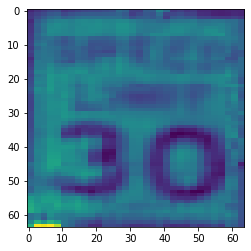

In [ ]:
# Load model
model = tf.keras.models.load_model('models/SpeedLimitCNN_Acc-90pct.model')

# Split test data into input images and labels
labels = [25,30,35,40,45,50]
test_inputs = [sample["image"] for sample in test_data]
test_labels = [sample["label"] for sample in test_data]

rand_idx = np.random.randint(0, len(test_labels))
rand_input, rand_label = test_inputs[rand_idx],test_labels[rand_idx]

imshow(rand_input)
print(f"Speed Limit: {rand_label}\nPredicted speed limit: {SpeedLimitCNN.predict(model, rand_input)[0]}")